In [9]:
import numpy as np
from sympy import *
from scipy.optimize import linprog
from copy import deepcopy

def branche_boundaries(F: str, constraint: list):
    '''
    inputs:
        F: function as a string (example: '2*x1 + 6*x2')
        constraint: restrictions in the form of a list of strings (example: ['x1 - x2 <= 4', '-3*x1 <= 17'])
    outputs:
        tuple: (point, result of function);
        example: (array([1., 5.]), 4.00000000000000)
    '''
    
    exp = sympify(F)
    
    count_constraint = int(input('Введите количество ограничений: '))
    
    symbs = sorted(list(exp.free_symbols), key=lambda x: str(x))
    
    c = [float(exp.coeff(symb)) for symb in symbs]
    
    dic_constr = {i: [] for i in range(1, count_constraint+1)}
    for i in range(len(constraint)):
        ineq = sympify(constraint[i])
        ex = ineq.args[0]
        dic_constr[i+1] = [float(ex.coeff(symb)) for symb in symbs]

    A = [v for v in dic_constr.values()]
    
    for i in range(len(symbs)):
        lst = [0.0]*len(symbs)
        lst[i] = -1.0
        A.append(lst)
    
    b = []
    for ineq in constraint:
        ine = sympify(ineq)
        b.append(ine.args[1])
    
    b += [0]*len(symbs)
    
    res = linprog(c, A_ub=A, b_ub=b, method='simplex')['x']
    
    if all(str(i).split('.')[-1] == '0' for i in res) \
            and all([sympify(const).subs(list(zip(symbs, res))) for const in constraint]):
        return res
    
    try:
        res_zlp1 = ZLP1(F, constraint, res, symbs, A, b, c)
    except:
        res_zlp1 = None
        
    try:
        res_zlp2 = ZLP2(F, constraint, res, symbs, A, b, c)
    except:
        res_zlp2 = None
    
    if res_zlp1 is not None and res_zlp2 is not None:
        if exp.subs(list(zip(symbs, res_zlp1))) <= exp.subs(list(zip(symbs, res_zlp2))):
            return res_zlp1, exp.subs(list(zip(symbs, res_zlp1)))
        else:
            return res_zlp2, exp.subs(list(zip(symbs, res_zlp2)))
    elif res_zlp1 is not None and res_zlp2 is None:
        return res_zlp1, exp.subs(list(zip(symbs, res_zlp1)))
    elif res_zlp1 is None and res_zlp2 is not None:
        return res_zlp2, exp.subs(list(zip(symbs, res_zlp2)))
    else:
        return None
    
def ZLP1(func, constraint, res_last, symbs, A, b, c):
    i = np.argmax(res_last%1)
    whole = int(res_last[i])
    lst = [0]*len(symbs)
    lst[i] = 1
    
    
    A_new = deepcopy(A)
    b_new = deepcopy(b)
    A_new.append(lst)
    b_new.append(whole)

    res = linprog(c, A_ub=A_new, b_ub=b_new, method='simplex')['x']
    
    
    if all(str(i).split('.')[-1] == '0' for i in res) \
            and all([sympify(const).subs(list(zip(symbs, res))) for const in constraint]):
        return res
    
    res_zlp3 = ZLP1(func, constraint, res, symbs, A_new, b_new, c)
    res_zlp4 = ZLP2(func, constraint, res, symbs, A_new, b_new, c)
    
    
    to_return = []
    if all(str(i).split('.')[-1] == '0' for i in res_zlp3) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp3))) for const in constraint]):
        to_return.append(res_zlp3)
    if all(str(i).split('.')[-1] == '0' for i in res_zlp4) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp4))) for const in constraint]):
        to_return.append(res_zlp4)
        
    if to_return:
        return to_return
    else:
        return None

def ZLP2(func, constraint, res_last, symbs, A, b, c):
    i = np.argmax(res_last%1)
    whole = -int(res_last[i])-1 
    lst = [0]*len(symbs)
    lst[i] = 1
    
    A_new = deepcopy(A)
    b_new = deepcopy(b)
    A_new.append(lst)
    b_new.append(whole)

    res = linprog(c, A_ub=A_new, b_ub=b_new, method='simplex')['x']
    
    if all(str(i).split('.')[-1] == '0' for i in res) \
            and all([sympify(const).subs(list(zip(symbs, res))) for const in constraint]):
        return res
    
    res_zlp5 = ZLP1(func, constraint, res, symbs, A_new, b_new, c)
    res_zlp6 = ZLP2(func, constraint, res, symbs, A_new, b_new, c)
    
    to_return = []
    if all(str(i).split('.')[-1] == '0' for i in res_zlp5) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp5))) for const in constraint]):
        to_return.append(res_zlp5)
    if all(str(i).split('.')[-1] == '0' for i in res_zlp5) \
            and all([sympify(const).subs(list(zip(symbs, res_zlp5))) for const in constraint]):
        to_return.append(res_zlp6)
        
    if to_return:
        return to_return
    else:
        return None

In [10]:
help(branche_boundaries)

Help on function branche_boundaries in module __main__:

branche_boundaries(F: str, constraint: list)
    inputs:
        F: function as a string (example: '2*x1 + 6*x2')
        constraint: restrictions in the form of a list of strings (example: ['x1 - x2 <= 4', '-3*x1 <= 17'])
    outputs:
        tuple: (point, result of function);
        example: (array([1., 5.]), 4.00000000000000)



# 1 - [6, 0] +

In [11]:
branche_boundaries(F='-2*x1 + 8*x2', constraint=['x1 + 2*x2 <= 16', '6*x1 + 2*x2 <= 40'])

Введите количество ограничений: 2


(array([6., 0.]), -12.0000000000000)

# 2 - [1, 1] - ядро умерло

In [12]:
branche_boundaries(F='x1 + x2', constraint=['x1 - 2*x2 <= 0', '-x1 + x2 <= 1', '-x1 + 0*x2 <= -0.75'])

Введите количество ограничений: 3


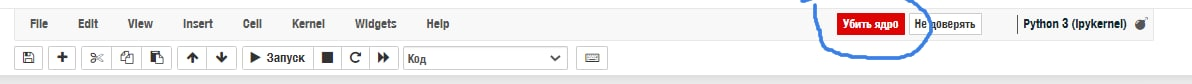

# 3 - [2, 1] +

In [13]:
branche_boundaries(F='-2*x1 + x2', constraint=['x1 - 2*x2 <= 0', '-x1 + x2 <= 1', 'x1 + x2 <= 3.2']) # если последнее условие
                                                                                                     # убрать, то не имеет 
                                                                                                     # допустимых решений

Введите количество ограничений: 3


(array([2., 1.]), -3.00000000000000)

# 4 - [1, 4] +

In [14]:
branche_boundaries(F='-10*x1 - x2', constraint=['x1 - 0.5*x2 <= -1', '2*x1 + x2 <= 6'])

Введите количество ограничений: 2


array([1., 4.])

# 5 - [0, 0] +

In [15]:
branche_boundaries(F='3*x1 + x2', constraint=['x1 + x2 <= 3.5', 'x1 + 0*x2 <= 2.25', '0*x1 + x2 <= 3'])

Введите количество ограничений: 3


array([0., 0.])

# 6 - [1, 3] +

In [18]:
branche_boundaries(F='-2*x1 - 4*x2', constraint=['2*x1 + x2 <= 6.4', 'x1 + 3*x2 <= 10'])

Введите количество ограничений: 2


(array([1., 3.]), -14.0000000000000)

# 7 - [1, 3] +

In [25]:
branche_boundaries(F='x1 - x2', constraint=['-x1 + 0.5*x2 <= 0.5', '2*x1 + x2 <= 6'])

Введите количество ограничений: 2


(array([1., 3.]), -2.00000000000000)

# 8 - [2, 0] +

In [26]:
branche_boundaries(F='-10*x1 - x2', constraint=['4*x1 + 5*x2 <= 20', '-x1 + 0.5*x2 <= 1', '0.5*x1 - x2 <= 1'])

Введите количество ограничений: 3


(array([2., 0.]), -20.0000000000000)

# 9 - [3, 1] - 

In [29]:
branche_boundaries(F='-3*x1 - 2*x2', constraint=['-x1 + 2*x2 <= 4', '3*x1 + 5*x2 <= 15', 'x1 - x2 <= 3'])

Введите количество ограничений: 3


(array([3., 0.]), -9.00000000000000)

# 10 - [0, 7] +

In [30]:
branche_boundaries(F='x1 - x2', constraint=['x1 - 2*x2 <= -4', '3*x1 + 2*x2 <= 14'])

Введите количество ограничений: 2


array([0., 7.])